# 1. Подключение пакетов и инициализация необходимых функций 

In [1]:
# data
# system
import os
import time
import math
import ast
# wfdm
import wfdb
# tqdm
from tqdm import tqdm
# numpy and pandas
import pandas as pd
import numpy as np
# sklearn
from sklearn.preprocessing import StandardScaler
# tslearn
from tslearn.utils import to_time_series, to_time_series_dataset, save_time_series_txt, load_time_series_txt
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesResampler, TimeSeriesScalerMeanVariance

# visualization
# matplotlib
import matplotlib.pyplot as plt
# seaborn
import seaborn as sns
# sktime
from sktime.utils.plotting import plot_series

# metrics
# sklearn
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, pairwise_distances, classification_report
# sktime
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError, MeanSquaredError, mean_absolute_percentage_error

# model
# sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV
# sktime
from sktime.classification.interval_based import TimeSeriesForestClassifier
# tslearn
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.svm import TimeSeriesSVC
# tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras import optimizers

np.random.seed(42)


In [2]:
# Transformations

def fourier_transform(X, coeffs=80):
    X_ft = np.empty_like(X)
    for i in range(len(X)):
        sample_fft = np.fft.rfft(X[i].T)
        indices = np.array([[j < coeffs for j, _ in enumerate(sample_fft[k])] for k in range(len(sample_fft))])
        X_ft[i] = np.fft.irfft(indices * sample_fft).T
    
    return X_ft

def rolling_average(X, n=4): # n - размер окна
    shape = list(X.shape)
    shape[1] -= n-1 
    X_ra = np.empty(shape)
    for i in range(len(X)):
        sample = X[i].T
        X_ra[i] = np.array([np.convolve(signal, np.ones(n), 'valid') / n for signal in sample]).T
    
    return X_ra

# Metrics and confusion matrix

def draw_confusion_matrix(y, y_pred):
    print(classification_report(y, y_pred))
    sns.heatmap(confusion_matrix(y, y_pred), square=True, annot=True, fmt='.0f', cmap=plt.cm.Blues)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    pass

# 2. Загрузка данных PTB-XL (physionet)

In [3]:
# def load_raw_data(df, sampling_rate, path):
#     if sampling_rate == 100:
#         data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
#     else:
#         data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
#     X_train_sum = np.array([signal for signal, meta in data])
#     return data

# path = 'ptbxl/'
# sampling_rate=100

# # load and convert annotation data
# Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
# Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# # Load raw signal data
# X = load_raw_data(Y, sampling_rate, path)

# # Load scp_statements.csv for diagnostic aggregation
# agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
# agg_df = agg_df[agg_df.diagnostic == 1]

# def aggregate_diagnostic(y_dic):
#     tmp = []
#     for key in y_dic.keys():
#         if key in agg_df.index:
#             tmp.append(agg_df.loc[key].diagnostic_class)
#     return list(set(tmp))

# # Apply diagnostic superclass
# Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# # Split data into train and test
# test_fold = 10
# # Train
# X_train = X[np.where(Y.strat_fold != test_fold)]
# y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# # Test
# X_test = X[np.where(Y.strat_fold == test_fold)]
# y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

# del X, Y

In [4]:
# print(X_train.shape, y_train.shape) # 19601 сэмпл, 1000 временных меток, 12 каналов
# print(type(X_train), type(y_train))

In [5]:
# X_train

In [6]:
# y_train

In [7]:
# y_train_np = y_train.to_numpy()
# unique = np.unique(y_train_np)
# print(unique)
# print(len(unique))

Всего 5 суперклассов: CD, HYP, NORM, MI, STTC. Как видно, среди меток присутствуют комбинации суперклассов. Посмотрим, сколько комбинаций содержится в y_test:

In [8]:
# y_test_np = y_test.to_numpy()
# unique = np.unique(y_test_np)
# print(len(unique))

# 2. Загрузка данных PTB-XL (helme)

In [148]:
X_train = np.load('ptbxl_helme/X_train_ptbxl_superdiag.npy')
X_test = np.load('ptbxl_helme/X_val_ptbxl_superdiag.npy')
y_train = np.load('ptbxl_helme/y_train_ptbxl_superdiag.npy')
y_test = np.load('ptbxl_helme/y_val_ptbxl_superdiag.npy')

In [7]:
# print(X_train.shape, y_train.shape)
# print(type(X_train), type(y_train))

In [6]:
# X_train

In [4]:
# y_train

In [5]:
# max([sum(y_train_dic) for y_train_dic in y_train])

[ 1 1 1 1 1] [1 1 0 0 0] [1 0 0 0 1] и др. когда на 1-м месте единица и ещё единица где то в списке быть не может, так как первый класс это NORM, а остальные диагнозы болезни  

### Визуализация

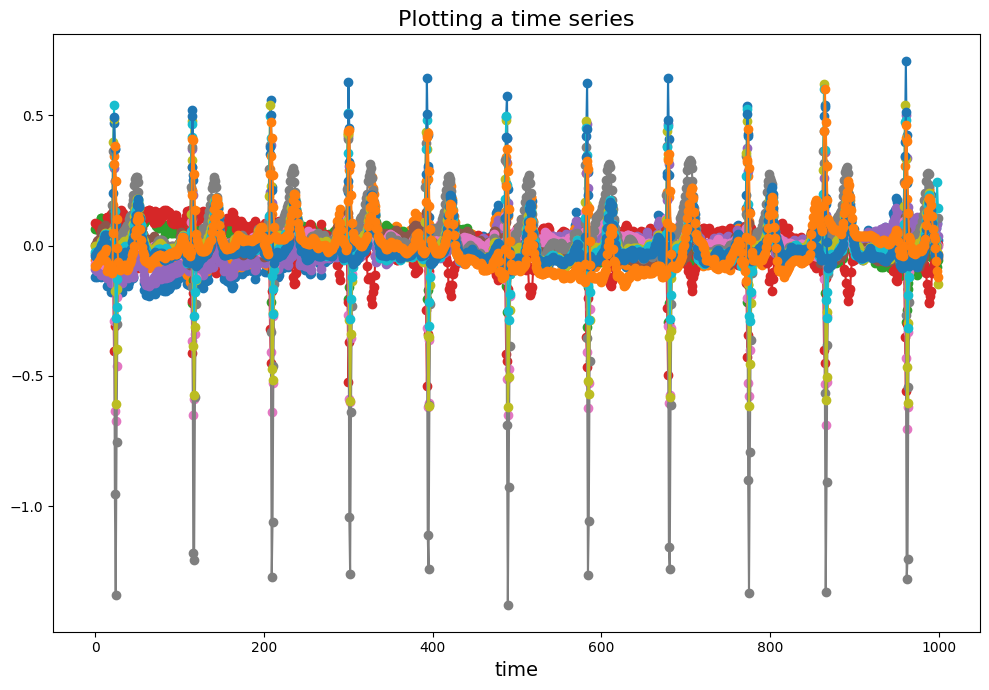

In [14]:
# plt.figure(figsize=(10, 7))
# plt.plot(X_train[0], 'o-', ) # все 12 отведений
# plt.xlabel('time', fontsize = 14)
# plt.title('Plotting a time series', fontsize = 16)
# plt.tight_layout()
# plt.show()

# Предобработка временных рядов

### Удаление многоклассовых меток

In [149]:
X_train = X_train[np.array([sum(x) for x in y_train]) == 1]
y_train = y_train[np.array([sum(x) for x in y_train]) == 1]
X_test = X_test[np.array([sum(x) for x in y_test]) == 1]
y_test = y_test[np.array([sum(x) for x in y_test]) == 1]

In [150]:
from tsaug import AddNoise

aug = AddNoise(scale=(0.01, 0.05))

selected_X = X_train[(y_train == [0, 1, 0, 0, 0]).all(axis = 1)]

X_aug = np.zeros((1021, 1000, 12))
for i in range(selected_X.shape[0]):
    X_aug[i] = aug.augment(selected_X[i])

X_train = np.concatenate((X_train, X_aug), axis=0)
y_train = np.concatenate((y_train, np.tile([0, 1, 0, 0, 0], (1021, 1))), axis = 0)
 
# Перемешаем массивы numpy

idx = np.random.permutation(X_train.shape[0])
X_train = X_train[idx]
y_train = y_train[idx]

print(X_train.shape)
print(y_train.shape)

(15615, 1000, 12)
(15615, 5)


In [151]:
def elimination_imbalance(X, y):
  n_classes = y.shape[1]
  unique = np.unique(y, axis = 0)
  for i in range(n_classes):
    index_want = (np.where((y == unique[i]).all(axis=1))[0])
    num_want = math.floor(index_want.shape[0]/100)*100
    if(num_want > 2000):
      num_want = 2000
    count_of_del = index_want.shape[0] - num_want
    index_to_remove = np.random.choice(np.where((y == unique[i]).all(axis=1))[0], size=count_of_del, replace=False)
    X = np.delete(X, index_to_remove, axis=0)
    y = np.delete(y, index_to_remove, axis=0)
  return X, y

def count_of_class(X, y):
  n_classes = y.shape[1]
  unique = np.unique(y, axis = 0)
  for i in range(n_classes):
    print(np.where((y_train == unique[i]).all(axis=1))[0].shape[0])   
    

In [154]:
count_of_class(X_train, y_train)
print(' ')
X_train, y_train = elimination_imbalance(X_train, y_train)
count_of_class(X_train, y_train)
print(X_train.shape, y_train.shape)

2000
2000
2000
1500
1500
 
2000
2000
2000
1500
1500
(9000, 1000, 12) (9000, 5)


# Преобразование Фурье

In [153]:
X_train_ft = fourier_transform(X_train)
X_test_ft = fourier_transform(X_test)

# Скользящее среднее

In [16]:
# X_train_ra = rolling_average(X_train)
# X_test_ft = rolling_average(X_test)

### Визуализация

In [46]:
# def plot_ts(x):
#   plt.figure(figsize=(14, 3))
#   plt.plot(x[0], 'o-', linewidth=1, markeredgewidth=0.01, alpha = 0.5 ) # все 12 отведений
#   plt.xlabel('time', fontsize = 14)
#   plt.title('Plotting a time series', fontsize = 16)
#   plt.tight_layout()
#   plt.show()

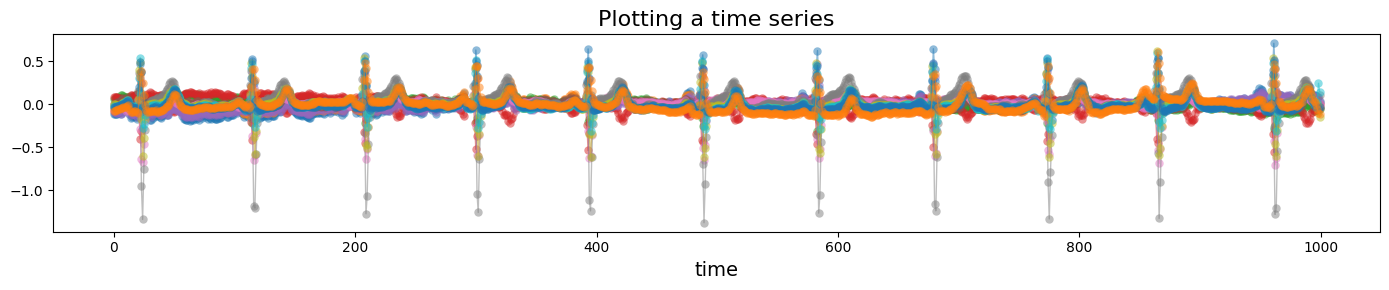

In [47]:
# plot_ts(X_train)

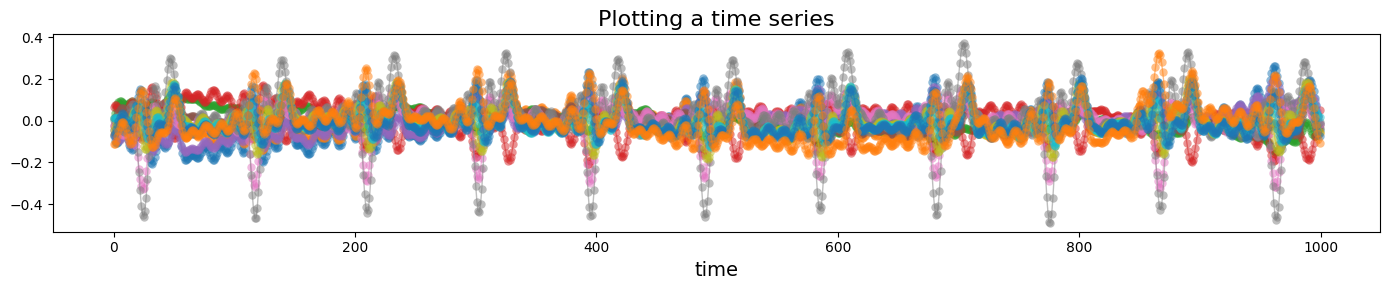

In [48]:
# plot_ts(X_train_ft)

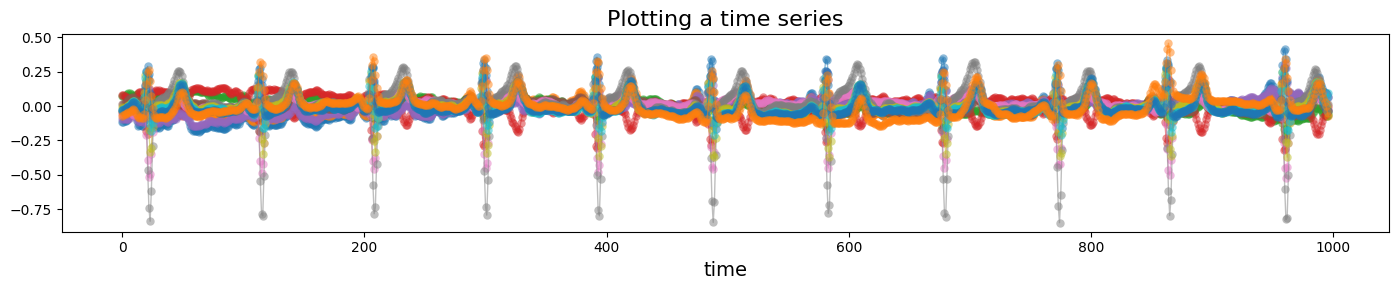

In [49]:
# plot_ts(X_train_ra)

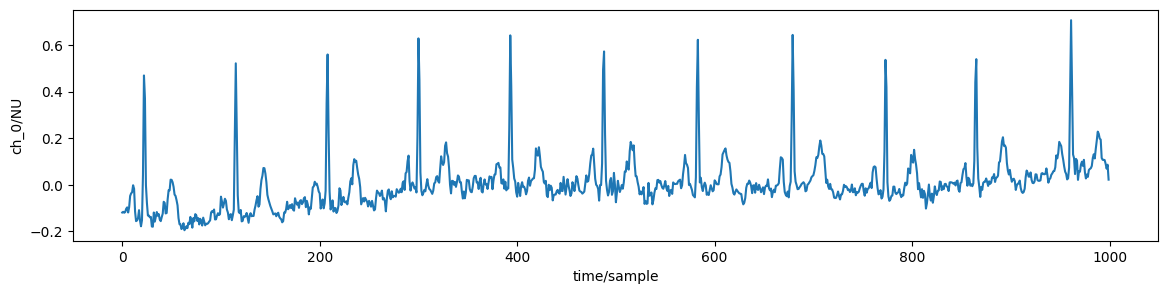

In [50]:
# wfdb.plot_items(signal = X_train[0, :, 0], figsize = (14, 3))

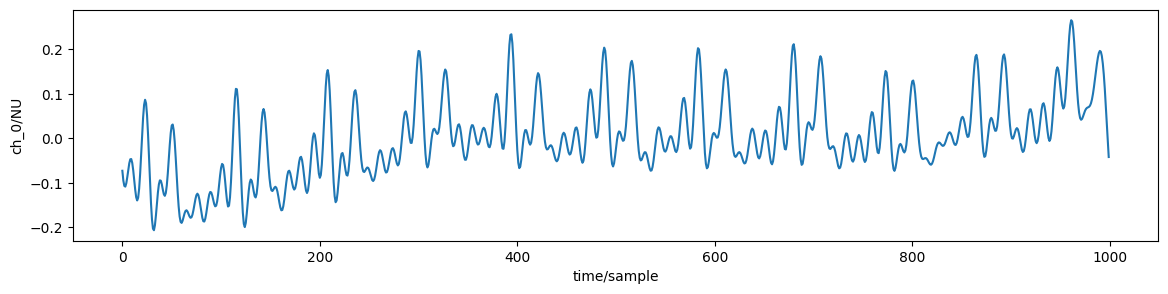

In [51]:
# wfdb.plot_items(signal = X_train_ft[0, :, 0], figsize = (14, 3))

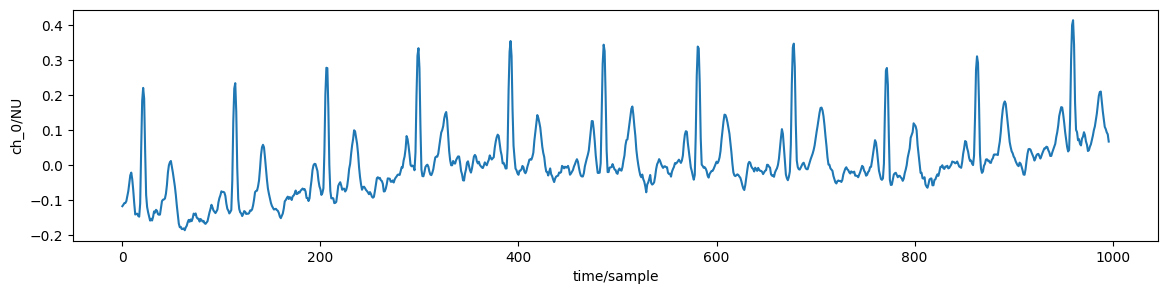

In [52]:
# wfdb.plot_items(signal = X_train_ra[0, :, 0], figsize = (14, 3))

# Применение алгоритмов машинного обучения
Рассматриваем следующие алгоритмы машинного обучения:
* Time Series Forest (простой алгоритм, не находит тренды, но иногда ведет себя хорошо)

* Bag-of-sfa-symbols ()

* Shaplet Classifier ()

* ROCKET (рандомная свертка)

* HIVE-COTE (ансамбль из выше перечисленных)

* NN

* кстати еще идея по трансформации: по сигналу зафигачить спектрограмму и получить картинку. С картинками много нейронок создано

In [5]:
def list_sum(X):
  X_sum = []
  for i in X:
    X_sum.append(np.reshape(i, 12000, order = 'A'))
  X_sum = np.array(X_sum)
  return X_sum

In [6]:
X_train_ft_sum = list_sum(X_train_ft)
X_train_sum = list_sum(X_train)
X_test_ft_sum = list_sum(X_test_ft)
X_test_sum = list_sum(X_test)

In [36]:
s = pd.Series(X_train_sum.ravel())


In [37]:
s

0           -0.119
1           -0.055
2            0.064
3            0.086
4           -0.091
             ...  
230759995    0.291
230759996    0.178
230759997    0.106
230759998    0.047
230759999   -0.103
Length: 230760000, dtype: float64

In [47]:
clf = TimeSeriesForestClassifier()
clf.fit(X_train_sum, np.argmax(y_train, axis=1))
y_pred = clf.predict(X_test_sum)


KeyboardInterrupt: 

In [ ]:
print(accuracy_score(y_test, y_pred))
clf.fit(X_train_ft_sum, y_train)
y_pred = clf.predict(X_test_ft_sum)
print(accuracy_score(y_test, y_pred))

# Аугментация данных